In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from bertopic import BERTopic
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#### Returns a tuple the first element is document_to_topic_tensor
#### The second element is topic_to_word_tensor 
#### Use the nr_topics_1 argument to specify the number of topics that should be present finally. If this parameter is too low
#### take a lot of time.
#### Use the words_per_topic argument to specify the number of representative words per topic. 

def generate_matrices(X,word_to_index, words_per_topic = 10,nr_topics_1 = None): 
    ### get target topics and probabilities of each document topic pair
    model = BERTopic(calculate_probabilities  = True , top_n_words = words_per_topic,nr_topics = nr_topics_1) 
    topics,probs = model.fit_transform(X) 
    
    ### calclate remaining topic probability as 1 - sum of given topic probabilities.
    document_to_topic_bas = probs  
    document_to_topic = [] 
    for i in range(len(document_to_topic_bas)): 
        sum1 = 0.0 
        for j in document_to_topic_bas[i]: 
            sum1 = sum1 + j 
        templ = [max(1-sum1,0.0)] 
        for j in document_to_topic_bas[i]: 
            templ.append(j) 
        document_to_topic.append(templ) 
    
    
    
    #print(topics[0] , document_to_topic[0])  
    
    vocab_len = len(list(word_to_index.items())) 
    
    topic_to_word_dict  = model.get_topics()
    topic_len = len(list(topic_to_word_dict.items())) 
  
    ## initialize topic_to_word matrix
    topic_to_word = [] 
    for i in range(topic_len):  
        temparr = []
        for j in range(vocab_len): 
            temparr.append(0) 
        topic_to_word.append(temparr) 
    
    
    for i in topic_to_word_dict: 
        temparr = topic_to_word_dict[i] 
        size = len(temparr) 
        for j in range(size): 
            if(temparr[j][0] in word_to_index): 
                 ## make sure that -1 corresponds to 0
                topic_to_word[i+1][word_to_index[temparr[j][0]]] = temparr[j][1]  
    
    ## convert to pytorch tensors.
    document_to_topic_tens = torch.tensor(document_to_topic) 
    topic_to_word_tens= torch.tensor(topic_to_word) 
    
    return (document_to_topic_tens,topic_to_word_tens) 
            


In [3]:
def get_word_pos():  
    word_to_index = dict() 
    embedding_dictionary = dict()
    count0 = 0
    with open('glove.6B.100d.txt' , 'r',encoding = 'utf-8') as f1: 
        for line in f1: 
            lis = line.split() 
            word_to_index[lis[0]] = count0  
            templist = []
            for index in range(1,len(lis)): 
                templist.append(float(lis[index])) 
            embedding_dictionary[lis[0]] = templist
            count0 = count0+1 
    return (word_to_index,embedding_dictionary)

In [4]:
data_set = pd.read_csv('FNC_Bin_Train.csv') 
full_set= data_set[:1000]  
newser = full_set['articleBody'] + full_set['Headline']
train_set = full_set[:800] 
test_set =  full_set[800:]

In [5]:
train_set,test_set = train_test_split(full_set,test_size = 0.2) 


In [6]:
print(train_set.shape) 
print(train_set.columns)

(800, 4)
Index(['Body ID', 'articleBody', 'Headline', 'Stance'], dtype='object')


In [7]:
imp_dic,ed = get_word_pos() 
doc2topic,topic2word = generate_matrices(newser.values,imp_dic) 


In [8]:


def parse_df_method_concat(inp,words_from_head,words_from_body,embedding_dict,topic2word,word2index): 
    final_feature = [] 
    topic2wordnum = topic2word.numpy() 
    el = len(embedding_dict[list(embedding_dict.items())[0][0]]) 
    tl  = topic2wordnum.shape[0] 
    
    for headlines,body in zip(inp['Headline'].values,inp['articleBody'].values): 
        record = []
        c0 = 0 
        for word in headlines: 
            temp = []
            if(word in embedding_dict): 
                 
                for j in embedding_dict[word]: 
                    temp.append(j) 
                for k in topic2wordnum[:,word2index[word]]: 
                    temp.append(k) 
            else: 
                for j in range(el+tl): 
                    temp.append(0.0) 
            c0 = c0 + 1
            record.append(temp) 
            if(c0 == words_from_head): 
                break 
        for i in range(words_from_head-c0): 
            temp = [] 
            for j in range(el+tl): 
                temp.append(0.0) 
            record.append(temp) 

### For body
        c0 = 0 
        for word in body: 
            temp = []
            if(word in embedding_dict): 
                 
                for j in embedding_dict[word]: 
                    temp.append(j) 
                for k in topic2wordnum[:,word2index[word]]: 
                    temp.append(k) 
            else: 
                for j in range(el+tl): 
                    temp.append(0.0) 
            c0 = c0 + 1
            record.append(temp) 
            if(c0 == words_from_body): 
                break 
        for i in range(words_from_body-c0): 
            temp = [] 
            for j in range(el+tl): 
                temp.append(0.0) 
            record.append(temp) 
        
        final_feature.append(record) 
    
    final_feature_tensor = torch.tensor(np.array(final_feature)) 
    final_target = torch.tensor(inp['Stance'].values) 
    return (final_feature_tensor,final_target)
            
                
                
                
            
    
    

In [9]:
print(topic2word.shape) 
print(doc2topic.shape)

torch.Size([43, 400000])
torch.Size([1000, 43])


In [10]:
X_train,y_train = parse_df_method_concat(train_set,12,300,ed,topic2word,imp_dic)

In [11]:
print(X_train.shape) 
print(y_train.shape)

torch.Size([800, 312, 143])
torch.Size([800])


In [12]:
X_test,y_test = parse_df_method_concat(test_set,12,300,ed,topic2word,imp_dic)

In [13]:
print(X_test.shape) 
print(y_test.shape)

torch.Size([200, 312, 143])
torch.Size([200])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
batch_size = 32
train_ds = TensorDataset(X_train,y_train) 
test_ds = TensorDataset(X_test,y_test) 
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [32]:
model = FNC_BERTopicModel(X_test.shape[2],12,300,70,15) 
model.to(device)  
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4) 


FNC_BERTopicModel(
  (lstm_head): LSTM(143, 70, batch_first=True)
  (lstm_body): LSTM(143, 70, batch_first=True)
  (fc_init): Linear(in_features=210, out_features=15, bias=True)
  (rel): ReLU()
  (fc_final): Linear(in_features=15, out_features=2, bias=True)
)


In [33]:
losses = trainer(model,optimizer,criterion,device) 
plt.plot(losses)

KeyboardInterrupt: 

In [26]:
finacc = tester(model,optimizer,device) 
print(finacc)

0.765625


In [36]:
model_dot = FNC_BERTopicModel_withDot(X_test.shape[2],12,300,70,15) 
model_dot.to(device)  
print(model_dot)
criterion_dot = nn.CrossEntropyLoss()
optimizer_dot = torch.optim.Adam(model_dot.parameters(), lr = 3e-4) 

FNC_BERTopicModel_withDot(
  (lstm_head): LSTM(143, 70, batch_first=True)
  (lstm_body): LSTM(143, 70, batch_first=True)
  (fc_init): Linear(in_features=211, out_features=15, bias=True)
  (rel): ReLU()
  (fc_final): Linear(in_features=15, out_features=2, bias=True)
)


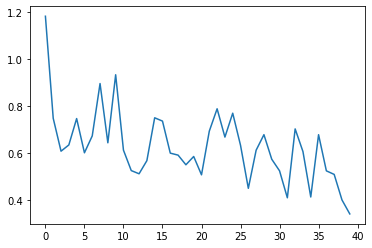

In [37]:
losses = trainer(model_dot,optimizer_dot,criterion_dot,device) 
plt.plot(losses)

In [38]:
finacc = tester(model_dot,optimizer_dot,device) 
print(finacc)

0.78125


In [17]:
class FNC_BERTopicModel(torch.nn.Module) :
    def __init__(self,  embedding_dim,words_in_head,words_in_body, hidden_dim=100, mlp_layers=100) :
        super().__init__()

        self.wh = words_in_head 
        self.wb = words_in_body

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm_head = nn.LSTM(embedding_dim, hidden_dim,batch_first= True)
        self.lstm_body = nn.LSTM(embedding_dim,hidden_dim,batch_first = True)
        # We use dropout before the final layer to improve with regularization
        

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc_init = nn.Linear(3*hidden_dim, mlp_layers) 
        self.rel = nn.ReLU()  
        self.fc_final = nn.Linear(mlp_layers,2)
        

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        outA,hiddenA = self.lstm_head(x[:,:self.wh,:]) 
        outB,hiddenB  = self.lstm_body(x[:,self.wh:,:])

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        hA = outA.sum(1) 
        hB = outB.sum(1)
        ### calculate_comps 
        compA = hA - hB 
        compB = torch.cat((hA,hB) , 1) 
        ##compC = torch.from_numpy(np.array([torch.dot(hA,hB)]))   
        
            
      
        fincomp = torch.cat((compB,compA) , 1) 
        
        ### feeding it to first_mlp 
        out_ua = self.fc_init(fincomp) 
        out_a = self.rel(out_ua)
        out_fin = self.fc_final(out_a)

        return out_fin, hidden
    
    def init_hidden(self):
        return (torch.zeros(1,batch_size,32), torch.zeros(1,batch_size,32))

In [28]:
class FNC_BERTopicModel_withDot(torch.nn.Module) :
    def __init__(self,  embedding_dim,words_in_head,words_in_body, hidden_dim=100, mlp_layers=100) :
        super().__init__()

        self.wh = words_in_head 
        self.wb = words_in_body

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm_head = nn.LSTM(embedding_dim, hidden_dim,batch_first= True)
        self.lstm_body = nn.LSTM(embedding_dim,hidden_dim,batch_first = True)
        # We use dropout before the final layer to improve with regularization
        

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc_init = nn.Linear(3*hidden_dim+1, mlp_layers) 
        self.rel = nn.ReLU()  
        self.fc_final = nn.Linear(mlp_layers,2)
        

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        outA,hiddenA = self.lstm_head(x[:,:self.wh,:]) 
        outB,hiddenB  = self.lstm_body(x[:,self.wh:,:])

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        hA = outA.sum(1) 
        hB = outB.sum(1)
        ### calculate_comps 
        compA = hA - hB 
        compB = torch.cat((hA,hB) , 1) 
        ##compC = torch.from_numpy(np.array([torch.dot(hA,hB)]))   
        dot_products = [] 
        for i in range(hA.shape[0]):  
            hAmod= torch.sqrt(torch.dot(hA[i,:],hA[i,:])) 
            hBmod = torch.sqrt(torch.dot(hB[i,:],hB[i,:]))
            dot_products.append([torch.dot(hA[i,:],hB[i,:])/((hAmod+1)*(hBmod+1))]) 
        compC = torch.tensor(dot_products,dtype = torch.float32) 
        
            
      
        fincomp = torch.cat((compB,compA,compC) , 1) 
        
        ### feeding it to first_mlp 
        out_ua = self.fc_init(fincomp) 
        out_a = self.rel(out_ua)
        out_fin = self.fc_final(out_a)

        return out_fin, hidden
    
    def init_hidden(self):
        return (torch.zeros(1,batch_size,32), torch.zeros(1,batch_size,32))

In [34]:
def trainer(train_model,train_optimizer,train_criterion,train_device):
    epochs = 40
    losses = []
    for e in range(epochs):

        h0, c0 =  train_model.init_hidden()

        h0 = h0.to(train_device)
        c0 = c0.to(train_device)

    #     for i in range(800):

    #         input = X_train[i,:,:] 
    #         input = input.to(torch.float32)
    #         target = y_train[i]

    #         optimizer.zero_grad()
    #         with torch.set_grad_enabled(True):
    #             out, hidden = model(input, (h0, c0))
    #             loss = criterion(out, target)
    #             loss.backward()
    #             optimizer.step() 
        for batch_idx, batch in enumerate(train_dl):

            input = batch[0].to(train_device)
            target = batch[1].to(train_device) 
            input = input.to(torch.float32)

            train_optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                out, hidden = train_model(input, (h0, c0))
                loss = train_criterion(out, target)
                loss.backward()
                train_optimizer.step()
        losses.append(loss.item()) 
    return losses 

In [35]:
def tester(test_model,test_optimizer,test_device):
    batch_acc = []
    for batch_idx, batch in enumerate(test_dl):
        h0, c0 =  test_model.init_hidden()
        input = batch[0].to(test_device)
        target = batch[1].to(test_device)
        input = input.to(torch.float32)
        test_optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            out, hidden = test_model(input, (h0, c0))
            _, preds = torch.max(out, 1)
            preds = preds.to("cpu").tolist()
            batch_acc.append(accuracy_score(preds, target.tolist()))

    return (sum(batch_acc)/len(batch_acc))

In [41]:
def train_and_test(model,model_name,device):  
    model.to(device)  
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4) 
    print("training begins")
    losses = trainer(model,optimizer,criterion,device) 
    print("training ends")
    print("losses are ")
    plt.plot(losses) 

    finacc = tester(model,optimizer,device) 
    print("for " + model_name + "accuracy is ")
    print(finacc)

FNC_BERTopicModel(
  (lstm_head): LSTM(143, 70, batch_first=True)
  (lstm_body): LSTM(143, 70, batch_first=True)
  (fc_init): Linear(in_features=210, out_features=15, bias=True)
  (rel): ReLU()
  (fc_final): Linear(in_features=15, out_features=2, bias=True)
)
training begins
training ends
losses are 
for FNC_Bert_no_dotaccuracy is 
0.7708333333333334


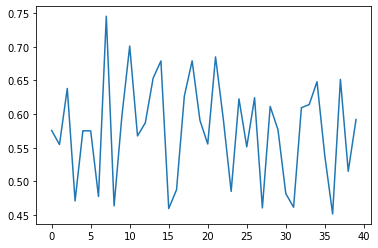

In [42]:
train_and_test(FNC_BERTopicModel(X_test.shape[2],12,300,70,15) , "FNC_Bert_no_dot" , device)

In [ ]:
train_and_test(FNC_BERTopicModel_withDot(X_test.shape[2],12,300,70,15) , "FNC_Bert_with_dot" , device)

FNC_BERTopicModel_withDot(
  (lstm_head): LSTM(143, 70, batch_first=True)
  (lstm_body): LSTM(143, 70, batch_first=True)
  (fc_init): Linear(in_features=211, out_features=15, bias=True)
  (rel): ReLU()
  (fc_final): Linear(in_features=15, out_features=2, bias=True)
)
training begins
